In [6]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 이미지에 들어가는 한글을 제대로 보기 위해 한글 폰트 적용
import platform
font_dict = {
    'Linux': 'Noto Sans CJK KR',
    'Darwin': 'Apple SD Gothic Neo', # macOS
    'Windows': 'Malgun Gothic' # MS-Windows
}
try:
    mpl.rc('font', family=font_dict[platform.system()])
except:
    pass
mpl.rc('axes', unicode_minus=False) # mpl.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [7]:
from pathlib import Path

data= Path('../data')

#라이브러리 불러오기

#입력 데이터 설정

In [13]:
# 위의 라벨링 데이터와는 별개의 mode 설정

condition = 1

if (condition==1):
    input_data = pd.read_csv(data / 'BABCdata_condition_1.csv')
elif (condition==2):
    input_data = pd.read_csv(data / 'BABCdata_edit_condition_2.csv')
elif (condition==3):
    input_data = pd.read_csv(data / 'BABCdata_condition_3.csv')
else:
    print("올바른 condition이 아닙니다.")

In [12]:
input_data.head()

,Unnamed: 0,TE_r,TE_t,TM_r,TM_t,layer3,n3,k3,d3,layer2,n2,k2,d2,layer1,n1,k1,d1,anlge
0,0,68.0107,8.110380e-77,65.6203,9.407930e-77,3.0,1.69,0.01,48.5,2.0,1.85,0.01,48.500,1.0,0.8808,2.778,1000.0,20.0
1,1,68.0126,8.109900e-77,65.6220,9.407460e-77,3.0,1.69,0.01,48.5,2.0,1.85,0.01,48.505,1.0,0.8808,2.778,1000.0,20.0
2,2,68.0146,8.109420e-77,65.6238,9.406990e-77,3.0,1.69,0.01,48.5,2.0,1.85,0.01,48.510,1.0,0.8808,2.778,1000.0,20.0
3,3,68.0165,8.108930e-77,65.6255,9.406520e-77,3.0,1.69,0.01,48.5,2.0,1.85,0.01,48.515,1.0,0.8808,2.778,1000.0,20.0
4,4,68.0184,8.108450e-77,65.6273,9.406050e-77,3.0,1.69,0.01,48.5,2.0,1.85,0.01,48.520,1.0,0.8808,2.778,1000.0,20.0


In [14]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1771561 entries, 0 to 1771560
Data columns (total 18 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   TE_r        float64
 2   TE_t        float64
 3   TM_r        float64
 4   TM_t        float64
 5   layer3      float64
 6   n3          float64
 7   k3          float64
 8   d3          float64
 9   layer2      float64
 10  n2          float64
 11  k2          float64
 12  d2          float64
 13  layer1      float64
 14  n1          float64
 15  k1          float64
 16  d1          float64
 17  anlge       float64
dtypes: float64(17), int64(1)
memory usage: 243.3 MB


In [15]:
input_data.describe()

,Unnamed: 0,TE_r,TE_t,TM_r,TM_t,layer3,n3,k3,d3,layer2,n2,k2,d2,layer1,n1,k1,d1,anlge
count,1.771561e+06,1.771561e+06,1.771561e+06,1.771561e+06,1.771561e+06,1771561.0,1.771561e+06,1.771561e+06,1.771561e+06,1771561.0,1.771561e+06,1.771561e+06,1.771561e+06,1771561.0,1.771561e+06,1.771561e+06,1771561.0,1771561.0
mean,8.857800e+05,5.160171e+01,1.222098e-76,5.074615e+01,1.340687e-76,3.0,1.750000e+00,2.000000e-02,2.500000e+01,2.0,1.850000e+00,2.100000e-02,2.500000e+01,1.0,8.808000e-01,2.778000e+00,1000.0,20.0
std,5.114058e+05,1.456796e+01,3.699419e-77,1.278897e+01,3.494640e-77,0.0,3.162279e-02,3.162279e-03,1.581139e+01,0.0,3.162279e-02,3.162279e-03,1.581139e+01,0.0,3.996804e-15,9.769965e-15,0.0,0.0
min,0.000000e+00,1.913840e+01,7.209890e-77,2.206820e+01,8.384830e-77,3.0,1.700000e+00,1.500000e-02,0.000000e+00,2.0,1.800000e+00,1.600000e-02,0.000000e+00,1.0,8.808000e-01,2.778000e+00,1000.0,20.0
25%,4.428900e+05,3.864270e+01,8.837610e-77,3.920900e+01,1.017440e-76,3.0,1.720000e+00,1.700000e-02,1.000000e+01,2.0,1.820000e+00,1.800000e-02,1.000000e+01,1.0,8.808000e-01,2.778000e+00,1000.0,20.0
50%,8.857800e+05,5.447500e+01,1.139370e-76,5.281080e+01,1.275040e-76,3.0,1.750000e+00,2.000000e-02,2.500000e+01,2.0,1.850000e+00,2.100000e-02,2.500000e+01,1.0,8.808000e-01,2.778000e+00,1000.0,20.0
75%,1.328670e+06,6.479020e+01,1.561450e-76,6.238500e+01,1.669600e-76,3.0,1.780000e+00,2.300000e-02,4.000000e+01,2.0,1.880000e+00,2.400000e-02,4.000000e+01,1.0,8.808000e-01,2.778000e+00,1000.0,20.0
max,1.771560e+06,7.126430e+01,2.089810e-76,6.887880e+01,2.159100e-76,3.0,1.800000e+00,2.500000e-02,5.000000e+01,2.0,1.900000e+00,2.600000e-02,5.000000e+01,1.0,8.808000e-01,2.778000e+00,1000.0,20.0


#라벨링 설정및 불필요 변수 제거

In [16]:
X_data = input_data.copy()

데이터 경량화(선택)

In [ ]:
# 전체적인 데이터량을 줄여버리는데 그중에 라벨링의 값이 40이 넘는 부분을 버린다.
#X_data = X_data[X_data.label < 40]

In [17]:
y = X_data['TE_r']

In [18]:
X_data.head()

,Unnamed: 0,TE_r,TE_t,TM_r,TM_t,layer3,n3,k3,d3,layer2,n2,k2,d2,layer1,n1,k1,d1,anlge
0,0,69.8447,9.699340e-77,67.5426,1.123680e-76,3.0,1.7,0.015,0.0,2.0,1.8,0.016,0.0,1.0,0.8808,2.778,1000.0,20.0
1,1,61.7972,1.210240e-76,59.8416,1.369030e-76,3.0,1.7,0.015,0.0,2.0,1.8,0.016,5.0,1.0,0.8808,2.778,1000.0,20.0
2,2,48.8629,1.580240e-76,48.3188,1.718480e-76,3.0,1.7,0.015,0.0,2.0,1.8,0.016,10.0,1.0,0.8808,2.778,1000.0,20.0
3,3,35.0265,1.944880e-76,37.0732,2.027110e-76,3.0,1.7,0.015,0.0,2.0,1.8,0.016,15.0,1.0,0.8808,2.778,1000.0,20.0
4,4,32.2103,1.961420e-76,35.0591,2.022830e-76,3.0,1.7,0.015,0.0,2.0,1.8,0.016,20.0,1.0,0.8808,2.778,1000.0,20.0


In [ ]:
# 일부분만 가져오는거로 바꿉시다.

X_data.rename(
    columns={''}
)

In [ ]:
X_data.head()

,n3,k3,d3,n2,k2,d2,n1,k1,d1,anlge
0,1.7,0.015,0.0,1.8,0.016,0.0,0.8808,2.778,1000.0,20.0
1,1.7,0.015,0.0,1.8,0.016,5.0,0.8808,2.778,1000.0,20.0
2,1.7,0.015,0.0,1.8,0.016,10.0,0.8808,2.778,1000.0,20.0
3,1.7,0.015,0.0,1.8,0.016,15.0,0.8808,2.778,1000.0,20.0
4,1.7,0.015,0.0,1.8,0.016,20.0,0.8808,2.778,1000.0,20.0


#고정변수 제거 (선택?)

In [ ]:
X_data.drop('anlge', axis=1 , inplace=True)

In [ ]:
X_data.drop('n1', axis=1, inplace=True)

In [ ]:
X_data.drop('k1', axis=1, inplace=True)

In [ ]:
X_data.drop('d1', axis=1, inplace=True)

In [ ]:
X_data.head()

,n3,k3,d3,n2,k2,d2
0,1.7,0.015,0.0,1.8,0.016,0.0
1,1.7,0.015,0.0,1.8,0.016,5.0
2,1.7,0.015,0.0,1.8,0.016,10.0
3,1.7,0.015,0.0,1.8,0.016,15.0
4,1.7,0.015,0.0,1.8,0.016,20.0


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
#from sklearn.model_selection import cross_val_score

# Train Test dataset 분리

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y, random_state=1234)

# Labeling 분포 확인

In [ ]:
y.value_counts().sort_index()

SyntaxError: ignored

In [ ]:
lab = y.values

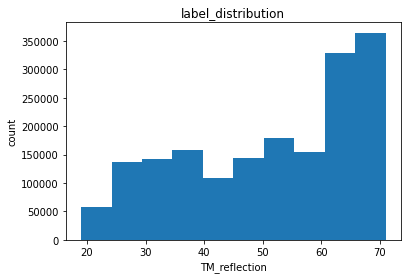

In [ ]:
plt.figure()
plt.hist(lab)
plt.title('label_distribution')
plt.xlabel('TM_reflection')
plt.ylabel('count')
#plt.show()
plt.savefig('/content/drive/My Drive/datasets/LithoAI/Condition3_TM.png')

# XGBClassfier 모델 생성

In [ ]:
bst = xgb.XGBClassifier(random_state=1234)

# XGBClassifier 모델의 학습

In [ ]:
# subsample 0.8이랑 0.6 차이 확인해보기
bst = xgb.XGBClassifier(n_estimators=281, learning_rate=0.2, max_depth=9, subsample=0.6, random_state=1234)

In [ ]:
evals = [(X_test,y_test)]
bst.fit(X_train, y_train, early_stopping_rounds=10, eval_metric = ["mlogloss","merror"], eval_set=evals, verbose=1)

[0]	validation_0-mlogloss:2.76704	validation_0-merror:0.596917
Multiple eval metrics have been passed: 'validation_0-merror' will be used for early stopping.

Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:2.44101	validation_0-merror:0.541047
[2]	validation_0-mlogloss:2.23625	validation_0-merror:0.510302
[3]	validation_0-mlogloss:2.07585	validation_0-merror:0.485514
[4]	validation_0-mlogloss:1.95024	validation_0-merror:0.466657
[5]	validation_0-mlogloss:1.83904	validation_0-merror:0.447519
[6]	validation_0-mlogloss:1.74451	validation_0-merror:0.430524
[7]	validation_0-mlogloss:1.65613	validation_0-merror:0.414698
[8]	validation_0-mlogloss:1.58227	validation_0-merror:0.400984
[9]	validation_0-mlogloss:1.5161	validation_0-merror:0.387452
[10]	validation_0-mlogloss:1.45499	validation_0-merror:0.375284
[11]	validation_0-mlogloss:1.40252	validation_0-merror:0.365858
[12]	validation_0-mlogloss:1.35112	validation_0-merror:0.354439
[13]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=281, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

# 모델 검증 및 시각화

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = bst.predict(X_test)
print('정확도 :', accuracy_score(y_test, y_pred.round()))


# Print a confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.astype(np.float).sum(axis=1)
plt.rcParams['figure.figsize'] = [10,8]
sns.heatmap(cm, annot=True)

정확도 : 0.9322858220194133


모델 오류 참고자료

https://github.com/dmlc/xgboost/issues/2073

https://github.com/dmlc/xgboost/issues/3828

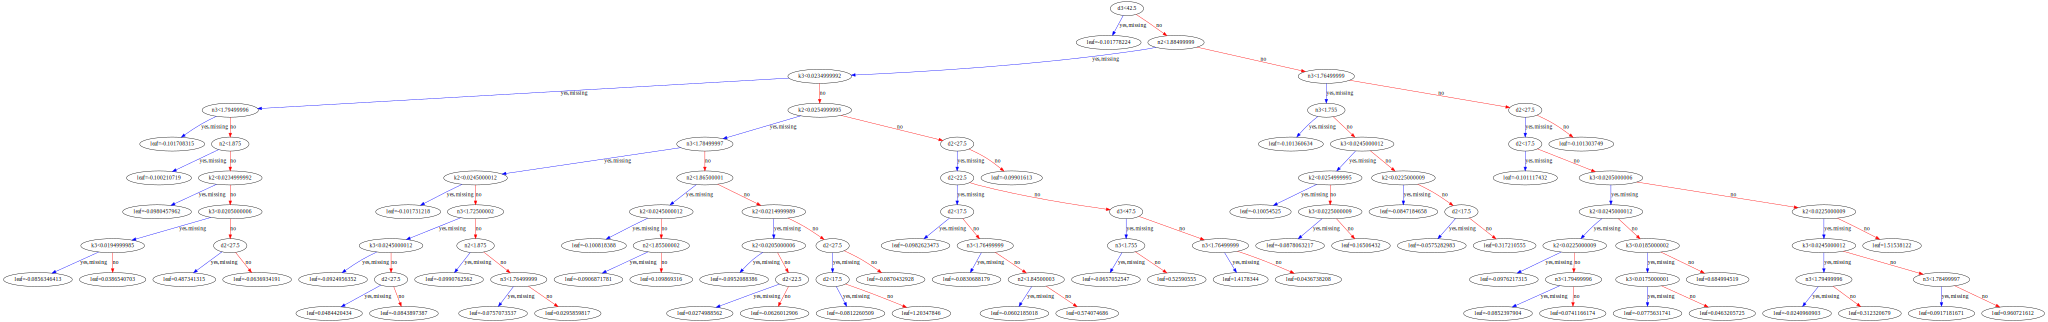

In [ ]:
# 방금시험했던 모델에서는 num_trees가 0~1799개 까지 있었다
xgb.to_graphviz(bst, num_trees=1)

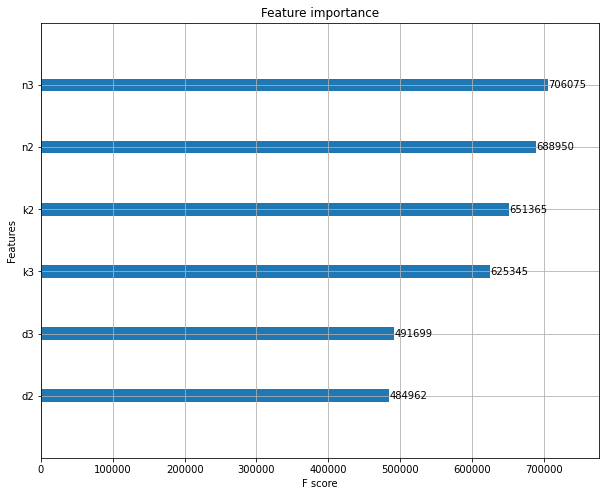

In [ ]:
# importance_type 얻을 수 있나싶네요
xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [10,8]

# 모델 튜닝

GridSearch 방법

In [ ]:
bst_param_grid = {
    'learning_rate' : [0.2, 0.3, 0.4],
    'max_depth' : [2, 3, 4],
}

bst_grid = GridSearchCV(bst, param_grid= bst_param_grid, scoring='accuracy', n_jobs=-1, verbose=1)
bst_grid.fit(X_train, y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
bst_grid_df = pd.DataFrame(bst_grid.cv_results_)
bst_grid_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_objective,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,75.608240,0.832305,1.348749,0.115887,multi:softmax,0.8,"{'objective': 'multi:softmax', 'subsample': 0.8}",0.676148,0.674460,0.673295,0.673001,0.671627,0.673706,0.001518,1
1,73.878399,1.876389,1.403999,0.083488,multi:softmax,1,"{'objective': 'multi:softmax', 'subsample': 1.0}",0.671574,0.666039,0.664658,0.664206,0.665070,0.666309,0.002701,3
2,74.607954,1.205587,1.323776,0.017499,multi:softprop,0.8,"{'objective': 'multi:softprop', 'subsample': 0.8}",0.676148,0.674460,0.673295,0.673001,0.671627,0.673706,0.001518,1
3,70.423602,1.615222,1.237543,0.194245,multi:softprop,1,"{'objective': 'multi:softprop', 'subsample': 1.0}",0.671574,0.666039,0.664658,0.664206,0.665070,0.666309,0.002701,3


베이지안 최적화 방법

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=4e4842a50d20b40d8285ae43f9ff33f43e72a6dff484fc4be7ac924809d756f0
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


https://www.kaggle.com/toastls93/bayes-optimization-xgb#XGB---learning_rate,-max_depth-%EB%93%B1-%EC%B5%9C%EC%A0%81%ED%99%94-%ED%95%98%EA%B8%B0

In [ ]:
def XGB_cv(max_depth,learning_rate, n_estimators, gamma
           ,min_child_weight, max_delta_step, subsample
           ,colsample_bytree, silent=True, nthread=-1):
    model = xgb.XGBClassifier(max_depth=int(max_depth),
                              learning_rate=learning_rate,
                              n_estimators=int(n_estimators),
                              silent=silent,
                              nthread=nthread,
                              gamma=gamma,
                              min_child_weight=min_child_weight,
                              max_delta_step=max_delta_step,
                              subsample=subsample,
                              colsample_bytree=colsample_bytree)
    RMSE = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=4).mean()
    return -RMSE

pbounds = {'max_depth': (5, 10),
          'learning_rate': (0.01, 0.3),
          'n_estimators': (50, 1000),
          'gamma': (1., 0.01),
          'min_child_weight': (1, 10),
          'max_delta_step': (0, 0.1),
          'subsample': (0.6, 0.9),
          'colsample_bytree' :(0.5, 0.99)
          }

xgboostBO = BayesianOptimization(f = XGB_cv,pbounds = pbounds, verbose = 2, random_state = 1234 )

# 메소드를 이용해 최대화!
xgboostBO.maximize(init_points=2, n_iter = 10)

xgboostBO.max

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.5377   |  0.5938   |  0.3841   |  0.1369   |  0.07854  |  8.9      |  3.453    |  312.6    |  0.8406   |
|  2        | -0.6369   |  0.9695   |  0.1328   |  0.1138   |  0.0501   |  8.417    |  7.414    |  401.7    |  0.7684   |
|  3        | -0.1859   |  0.556    |  0.01     |  0.06995  |  0.04435  |  5.82     |  6.244    |  50.04    |  0.7004   |
|  4        | -0.1801   |  0.5901   |  0.01     |  0.09931  |  0.008554 |  9.612    |  3.407    |  50.42    |  0.7209   |
|  5        | -0.6598   |  0.6004   |  0.01     |  0.2578   |  0.03073  |  9.78     |  2.304    |  999.6    |  0.6251   |
|  6        | -0.2064   |  0.5291   |  0.01     |  0.2395   |  0.03506  |  5.121    |  1.268    |  50.54    |  0.6383   |
|  7        | -0.3714   

{'params': {'colsample_bytree': 0.8506945992820225,
  'gamma': 0.01,
  'learning_rate': 0.1448396938292427,
  'max_delta_step': 0.03771802050604797,
  'max_depth': 9.890127006274056,
  'min_child_weight': 9.110813179479896,
  'n_estimators': 50.57849069226247,
  'subsample': 0.8034242734858654},
 'target': -0.17580640095480382}

In [ ]:
fit_xgb = xgb.XGBClassifier(max_depth= int( xgboostBO.max['params']['max_depth'] ),
                             learning_rate=xgboostBO.max['params']['learning_rate'],
                             n_estimators=int(xgboostBO.max['params']['n_estimators']),
                             gamma= xgboostBO.max['params']['gamma'],
                             min_child_weight=xgboostBO.max['params']['min_child_weight'],
                             max_delta_step=xgboostBO.max['params']['max_delta_step'],
                             subsample=xgboostBO.max['params']['subsample'],
                             colsample_bytree=xgboostBO.max['params']['colsample_bytree'])

In [ ]:
model  = fit_xgb.fit(X,y)

# 모델 저장

제대로 저장이 안되는 느낌
colab 환경이라 그런가?

In [ ]:
bst.save_model('/content/drive/My Drive/datasets/model.bst')

# 모델 저장및 불러오기 위해서 필요한 툴

https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/xgboost_caip_e2e.ipynb

In [ ]:
import sys
python_version = sys.version_info[0]

In [ ]:
# If you're running on Colab, you'll need to install the What-if Tool package and authenticate
# If you're on Cloud AI Platform Notebooks, you'll need to install XGBoost on the TF instance
def pip_install(module):
    if python_version == '2':
        !pip install {module} --quiet
    else:
        !pip3 install {module} --quiet

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    pip_install('witwidget')

    from google.colab import auth
    auth.authenticate_user()
else:
    pip_install('xgboost')

     |████████████████████████████████| 2.3MB 2.7MB/s 


In [ ]:
import numpy as np
import collections
import witwidget

from sklearn.utils import shuffle
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

In [ ]:
# Define some globals - update these to your own project + model names
GCP_PROJECT = 'YOUR_GCP_PROJECT'
MODEL_BUCKET = 'gs://your_storage_bucket'
MODEL_NAME = 'case1' # You'll create this model below
VERSION_NAME = 'v1'

In [ ]:
# Copy your model file to Cloud Storage
!gsutil cp ./model.bst $MODEL_BUCKET

Copying file://./model.bst [Content-Type=application/octet-stream]...
NotFoundException: 404 The destination bucket gs://your_storage_bucket does not exist or the write to the destination must be restarted


In [ ]:
# Configure gcloud to use your project
!gcloud config set project $GCP_PROJECT

In [ ]:
# Create a model
!gcloud ai-platform models create $MODEL_NAME

In [ ]:
# Create a version, this will take ~2 minutes to deploy
!gcloud ai-platform versions create $VERSION_NAME \
--model=$MODEL_NAME \
--framework='XGBOOST' \
--runtime-version=1.14 \
--origin=$MODEL_BUCKET \
--python-version=3.5 \
--project=$GCP_PROJECT

In [ ]:
# Format a subset of the test data to send to the What-if Tool for visualization
# Append ground truth label value to training data

# This is the number of examples you want to display in the What-if Tool
num_wit_examples = 500
test_examples = np.hstack((X_test[:num_wit_examples].values,y_test[:num_wit_examples].reshape(-1,1)))

In [ ]:
# Create a What-if Tool visualization, it may take a minute to load
# See the cell below this for exploration ideas

# This prediction adjustment function is needed as this xgboost model's
# prediction returns just a score for the positive class of the binary
# classification, whereas the What-If Tool expects a list of scores for each
# class (in this case, both the negative class and the positive class).
def adjust_prediction(pred):
  return [1 - pred, pred]

config_builder = (WitConfigBuilder(test_examples.tolist(), data.columns.tolist() + ['mortgage_status'])
  .set_ai_platform_model(GCP_PROJECT, MODEL_NAME, VERSION_NAME, adjust_prediction=adjust_prediction)
  .set_target_feature('mortgage_status')
  .set_label_vocab(['denied', 'approved']))
WitWidget(config_builder, height=800)

# 모델 로드

In [ ]:
xgbc = xgb.XGBClassifier(random_state=1234)
xgbc.load_model('/content/drive/My Drive/datasets/model.bst')